In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, StratifiedKFold
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score, auc, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, f1_score
from sklearn import tree 
import xgboost as xgb_package
import seaborn as sns

In [2]:
#reading files
all_pairs = pd.read_csv("all_pairs.csv", sep= ";")
all_pairs = all_pairs.dropna(how='all')              # drops fully empty rows
all_pairs = all_pairs.dropna(axis=1, how='all')      # drops fully empty columns

In [3]:
all_pairs = all_pairs[(all_pairs['neighbour DisProt IDP'] == 1)]
all_pairs.shape

(1160, 84)

In [4]:
npos = len(all_pairs[all_pairs['neighbour biomarker for target?'] == 1])
print(npos)

160


In [5]:
# Defining positive control
training_pos =all_pairs[all_pairs['neighbour biomarker for target?'] == 1]

In [6]:
# Negative control = not biomarker in CIViCmine + random sampling
training_neg = all_pairs[
    (all_pairs['neighbour biomarker for target?'] == 0) &
    (all_pairs['prognostic'] == 0) &
    (all_pairs['predisposing'] == 0) &
    (all_pairs['diagnostic'] == 0) &
    (all_pairs['predictive'] == 0)]
nneg = len(training_neg)
print(nneg)
training_neg_extra = all_pairs[all_pairs['neighbour biomarker for target?'] == 0].sample(n=(npos-nneg), random_state=42)
training_neg = pd.concat([training_neg_extra, training_neg], ignore_index=True)
training_neg.shape

18


(160, 84)

In [7]:
training = pd.concat([training_pos, training_neg], ignore_index=True)

In [8]:
unknown = all_pairs.merge(training, how='outer', indicator=True)\
                          .query('_merge == "left_only"')\
                          .drop(columns=['_merge'])

In [9]:
#titles list
titles = list(training.head())
CSN = [s for s in titles if "CSN" in s]
SIGNOR = [s for s in titles if "SIGNOR" in s]
ReactomeFI = [s for s in titles if "ReactomeFI" in s]
print(CSN, SIGNOR, ReactomeFI)

['neighbour in CSN', 'target in CSN', 'both in CSN', 'in triangle - CSN', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'DisProt neighbour third partner - CSN', 'target third partner - CSN', 'neighbour bridgeness - CSN', 'neighbour betweenness - CSN', 'target bridgeness - CSN', 'target betweenness - CSN'] ['neighbour in SIGNOR', 'target in SIGNOR', 'both in SIGNOR', 'in  triangle - SIGNOR', 'no. of triangles - SIGNOR', 'no. of in  cycle - SIGNOR', 'no. of in  unbalanced triangle - SIGNOR', 'neighbour – target inhibition - SIGNOR', 'target – neighbour stimulation - SIGNOR', 'neighbour – target stimulation - SIGNOR', 'target – neighbour inhibition - SIGNOR', 'DisProt neighbour third partner - SIGNOR', 'target third partner - SIGNOR', 'neighbour bridgeness - SIGNOR', 'neighbour betweenness 

In [10]:
#what to drop
to_drop = ["neighbour UniProt", "neighbour name - universal", "target UniProt", "target name - universal", 
           "prognostic", "predisposing", "diagnostic", "predictive",
           "neighbour DisProt IDP", "neighbour in AlphaFold", "neighbour AlphaFold average pLLDT", 
           "neighbour AlphaFold disorder %", "neighbour in IUPred", "neighbour IUPred long score", 
           "neighbour IUPred long disorder %", "neighbour IUPred short score", 
           "neighbour IUPred short disorder %", "target AlphaFold average pLLDT",
           "target AlphaFold disorder %", "target IUPred long score", "target IUPred long disorder %", 
           "target IUPred short score", "target IUPred short disorder %"]
only_CSN = to_drop + SIGNOR + ReactomeFI
only_SIGNOR = to_drop + CSN + ReactomeFI 
only_ReactomeFI = to_drop + CSN + SIGNOR

In [11]:
#data preparation
def prepare_data(training=training, unknown=unknown, to_drop= to_drop):
    """
    This function prepares the training and unknown data for the machine learning.
    Drops the previously selected columns using the to_drop list without renaming the remaining columns.
    Splits the training data to input parameters and labels.

    Args:
        to_drop: The list of column names which are going to be dropped from the training and unknown dataframe. 
        training: The dataframe of input parameters which are intended to use to the training of the machine learning model.
        unknown: The dataframe of input parameters which are intended to use to the testing of the machine learning model.

    Returns:
        U: The input data from the unknown dataframe.
        X: The input data from the training dataframe.
        y: The labels for the training dataframe.

    """
    training_deleted = training.drop(columns= to_drop)
    U = unknown.drop(columns= to_drop)
    X = training_deleted.iloc[:,:-1]
    y = training_deleted.iloc[:, -1]
    return U, X, y

In [12]:
#classifiers - hyperparameters optimalised
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state=42,
                                subsample= 0.75,
                                scale_pos_weight= 0.25,
                                reg_lambda= 0,
                                reg_alpha= 0.5,
                                min_child_weight= 0.5,
                                max_leaves= 11,
                                max_depth= 7,
                                max_delta_step= 1,
                                max_bin= 32,
                                learning_rate= 1,
                                importance_type= 'cover',
                                grow_policy= 'lossguide',
                                gamma= 0.5,
                                criterion= 'log_loss',
                                booster= 'gbtree')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False, #disabled, otherwise gives error with multiple training sets
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0.1,
                             min_samples_split= 4,
                             min_samples_leaf= 5,
                             max_samples= 71,
                             max_leaf_nodes= 29,
                             max_features= 'sqrt',
                             max_depth= 3,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)

In [13]:
#teaching - ROC function
def teach_print_ROC(classifier, X_train, X_test, y_train, y_test, ax1):
    """
    This function teaches and tests the selected machine learning models while drawing the ROC curve.
    Fits StandardScaler on the training data and transforms the training and test data.
    Makes predictions on the training and test dataframes.
    Draws the ROC curve.

    Args:
        X_train: The input data which will be used for training the model.
        X_test: The input data which will be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.
        classifier: The choosen classification algorhythm.
        ax1: The axis of the ROC curve.
        
    Returns:
        None

    """
    #fitting the scale
    scale = StandardScaler()
    scale.fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)
    
    #teaching
    classifier.fit(X_train, y_train)

    classifier_pred_train = classifier.predict(X_train)

    classifier_pred_test = classifier.predict(X_test)
    
    #test ROC curve
    classifier_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax1, alpha=0.8, )

In [14]:
#teaching - parameters function
def teach_print_params(classifier, X_train, X_test, y_train, y_test, accuracies):
    """
    This function teaches and tests the selected machine learning models while also calculating accuracy metrics.
    Fits StandardScaler on the training data and transforms the training and test data.
    Makes predictions on the training and test dataframes.
    Calculates the probabilities of assigning the given element to each label.
    Calculates and returns accuracy.

    Args:
        X_train: The input data which will be used for training the model.
        X_test: The input data which will be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.
        classifier: The choosen classification algorhythm.
        accuracies: A list ready to store the accuracy data of the current model. Contains the previous accuracy scores.

    Returns:
        acc: The accuracy score of the current prediction on the test data.
        accuracies: The list of accuracies complemented with the current accuracy values.
        proba0: The probability of label "0" = "not predictive biomarker".
        proba1: The probability of label "1" = "predictive biomarker".

    """
    #fitting the scale
    scale = StandardScaler()
    scale.fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)
    
    #teaching
    classifier.fit(X_train, y_train)

    classifier_pred_train = classifier.predict(X_train)

    classifier_pred_test = classifier.predict(X_test)
    classifier_pred_proba = classifier.predict_proba(X_test)
    
    #accuracy
    acc = accuracy_score(y_test, classifier_pred_test)
    accuracies.append(acc)
    
    #probas
    proba0 = classifier_pred_proba[:, 0]
    proba1 = classifier_pred_proba[:, 1]
    
    return acc, accuracies, proba0, proba1

In [15]:
#LOOCV - function
def LOOCV(machine_learning, classifier, X, y, details=""):
    """
    This function runs a Leave-One-Out-CrossValidation method on the choosen classifier and input data.
    Splits the X dataset to test data in the size of 1 element.
    Defines empty list for the storage of the metrics calculated of the machine learning algorhythm.
    Runs the previously defined machine learning function in a for cycle run on the all possible splitting of the input data.
    Lists and prints the indexes of test elements that were not predicted correctly.
    Makes and returns a dataframe about the probability of label "0" = not predictive biomarker and "1" = predictive biomarker.
    Plots the accuracies with the test indexes.
    Calculates the average accuracy.

    Args:
        machine_learning: The choosen previously defined function for machine learning.
        classifier: The choosen classification algorhythm.
        X: The input data from the dataframe.
        y: The labels for the dataframe.
        details: The details included in the title of the accuracy-index curve.

    Returns:
        average: The average of accuracy values.
        probas: The probability dataframe of the test elements regarding label "0" and "1".

    """

    loo = LeaveOneOut()
    loo.get_n_splits(X)

    print(loo)
    ax1 = plt.gca()

    accuracies = []
    misses = []
    probas0 = []
    probas1 = []
    y_tests = []
    
    for train_index, test_index in loo.split(X):
        print(test_index)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        acc, accuracies, proba0, proba1 = machine_learning(classifier=classifier, X_train=X_train, X_test=X_test, 
                                           y_train=y_train, y_test=y_test,
                                           accuracies=accuracies)
        if acc == 0:
            misses.append(test_index)
            
        probas0.append(proba0)
        probas1.append(proba1)
        y_tests.append(y_test)

    plt.plot(accuracies)
    plt.title(f"Accuracies vs LOOCV{details}")
    plt.show()
    average= sum(accuracies) / len(accuracies)
    print(f"Average accuracy:\n{average}")
    print(f"Indexes of misses:\n{misses}")
    probas = pd.DataFrame(list(zip(y_tests, probas0, probas1)),
               columns =['label', 'proba0', 'proba1'])
    
    return average, probas

In [16]:
#crossvalidation average ROC
def plot_average_ROC(classifier, details="", splits=10):
    """
    This function runs an X-fold cross validation method on the choosen classifier and input data.
    Splits the X dataset to X different test datasets in the same size.
    Draws the average ROC curve with standard deviation.

    Args:
        classifier: The choosen classification algorhythm.
        details: The details included in the title of the average ROC curve.
        splits: The number of splits used in the cross validation process.
        
    Returns:
        None

    """
    cv = StratifiedKFold(n_splits=splits)
    classifier = classifier

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.loc[train], y.loc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.loc[test],
            y.loc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"ROC curve - {details}",
    )
    ax.legend(loc="lower right")
    plt.show()

XGBoost results:
LeaveOneOut()
[0]
[18:06:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[1]
[18:06:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[2]
[18:06:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "crit

[20]
[18:06:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21]
[18:06:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22]
[18:06:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[40]
[18:06:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[41]
[18:06:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[42]
[18:06:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[60]
[18:06:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[61]
[18:06:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[62]
[18:06:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[80]
[18:07:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[81]
[18:07:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[82]
[18:07:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[100]
[18:07:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[101]
[18:07:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[102]
[18:07:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[120]
[18:07:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[121]
[18:07:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[122]
[18:07:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[140]
[18:07:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[141]
[18:07:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[142]
[18:07:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[160]
[18:07:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[161]
[18:07:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[162]
[18:07:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[180]
[18:07:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[181]
[18:07:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[182]
[18:07:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[200]
[18:07:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[201]
[18:07:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[202]
[18:07:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[220]
[18:07:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[221]
[18:07:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[222]
[18:07:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[240]
[18:08:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[241]
[18:08:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[242]
[18:08:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[260]
[18:08:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[261]
[18:08:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[262]
[18:08:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[280]
[18:08:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[281]
[18:08:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[282]
[18:08:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[300]
[18:08:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[301]
[18:08:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[302]
[18:08:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

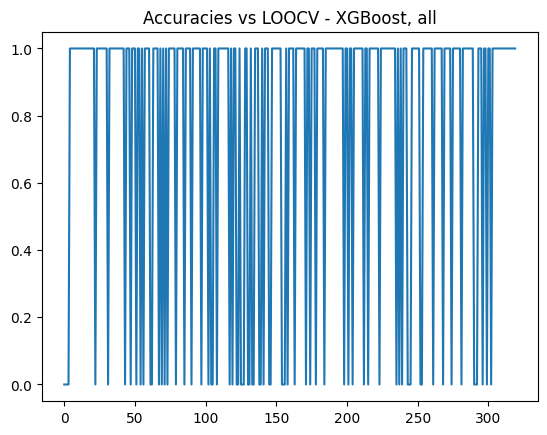

Average accuracy:
0.76875
Indexes of misses:
[array([0]), array([1]), array([2]), array([3]), array([22]), array([31]), array([43]), array([47]), array([51]), array([54]), array([56]), array([61]), array([62]), array([67]), array([69]), array([71]), array([73]), array([79]), array([85]), array([90]), array([97]), array([102]), array([104]), array([105]), array([108]), array([117]), array([119]), array([122]), array([123]), array([125]), array([126]), array([127]), array([130]), array([131]), array([133]), array([134]), array([138]), array([139]), array([141]), array([145]), array([146]), array([154]), array([155]), array([156]), array([158]), array([163]), array([171]), array([174]), array([178]), array([184]), array([198]), array([201]), array([204]), array([212]), array([215]), array([223]), array([235]), array([237]), array([239]), array([243]), array([244]), array([245]), array([252]), array([253]), array([261]), array([268]), array([274]), array([281]), array([290]), array([291]),

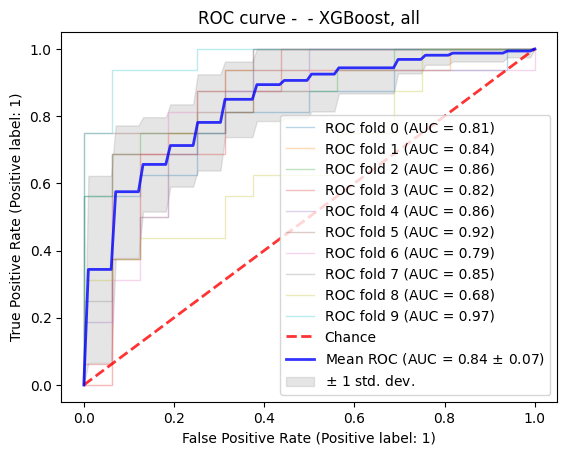

Random forest results:
LeaveOneOut()
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]

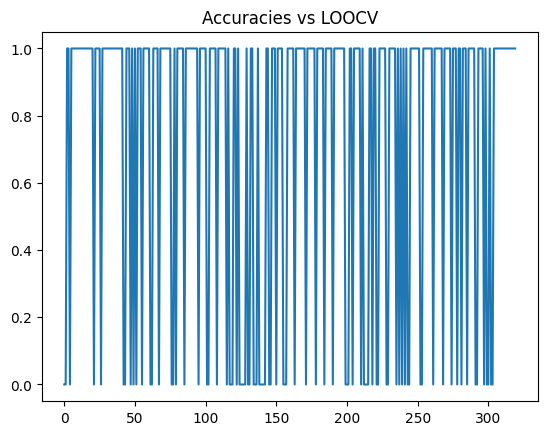

Average accuracy:
0.725
Indexes of misses:
[array([0]), array([1]), array([4]), array([21]), array([26]), array([42]), array([43]), array([47]), array([49]), array([51]), array([55]), array([61]), array([62]), array([67]), array([76]), array([77]), array([79]), array([85]), array([95]), array([101]), array([102]), array([108]), array([115]), array([117]), array([118]), array([119]), array([122]), array([124]), array([125]), array([126]), array([127]), array([128]), array([130]), array([131]), array([134]), array([135]), array([136]), array([138]), array([139]), array([140]), array([141]), array([142]), array([145]), array([146]), array([150]), array([155]), array([156]), array([157]), array([163]), array([171]), array([178]), array([184]), array([190]), array([199]), array([200]), array([201]), array([204]), array([210]), array([212]), array([213]), array([214]), array([215]), array([218]), array([221]), array([222]), array([228]), array([229]), array([235]), array([237]), array([239])

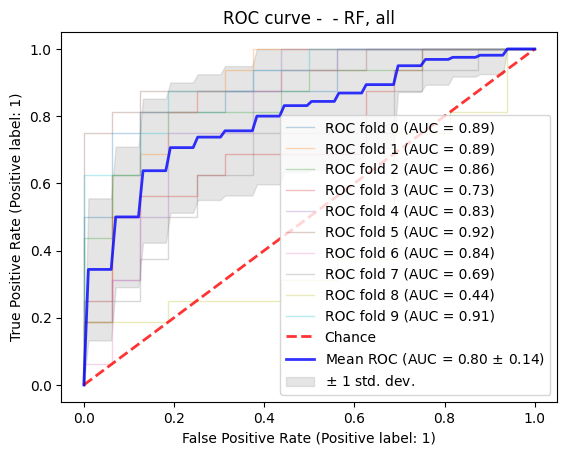

In [17]:
#basic - data of all networks
#sys.exc_clear() 
U, X, y = prepare_data()
print("XGBoost results:")
xgb_average, probas_xgb = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=xgb, details=" - XGBoost, all")
plot_average_ROC(classifier=xgb, details=" - XGBoost, all")
print("Random forest results:")
rfc_average, probas_rfc = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=rfc)
plot_average_ROC(classifier=rfc, details=" - RF, all")
basic_averages = xgb_average, rfc_average

['neighbour in CSN', 'neighbour DisProt disorder content', 'neighbour preclinical target', 'neighbour MCG target', 'target in CSN', 'target of small molecule', 'target of antibody', 'target DisProt IDP', 'target DisProt disorder content', 'both in CSN', 'both in all 3', 'in triangle - CSN', 'not in any triangle', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'DisProt neighbour third partner - CSN', 'target third partner - CSN', 'neighbour bridgeness - CSN', 'neighbour betweenness - CSN', 'target bridgeness - CSN', 'target betweenness - CSN']
XGBoost results:
LeaveOneOut()
[0]
[18:16:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used 

[18]
[18:16:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19]
[18:16:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20]
[18:16:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[38]
[18:16:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[39]
[18:16:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[40]
[18:16:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[58]
[18:16:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[59]
[18:16:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[60]
[18:16:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[78]
[18:16:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[79]
[18:16:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[80]
[18:16:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[98]
[18:16:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[99]
[18:16:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[100]
[18:16:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

[118]
[18:16:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[119]
[18:16:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[120]
[18:16:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[138]
[18:16:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[139]
[18:16:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[140]
[18:16:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[158]
[18:17:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[159]
[18:17:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[160]
[18:17:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[178]
[18:17:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[179]
[18:17:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[180]
[18:17:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[198]
[18:17:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[199]
[18:17:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[200]
[18:17:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[218]
[18:17:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[219]
[18:17:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[220]
[18:17:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[238]
[18:17:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[239]
[18:17:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[240]
[18:17:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[258]
[18:17:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[259]
[18:17:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[260]
[18:17:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[278]
[18:17:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[279]
[18:17:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[280]
[18:17:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[298]
[18:17:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[299]
[18:17:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[300]
[18:17:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[318]
[18:18:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[319]
[18:18:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




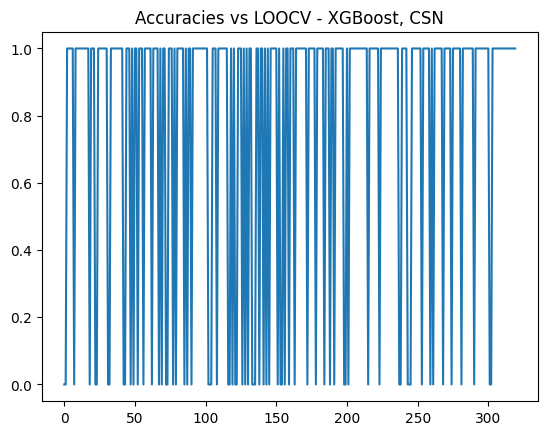

Average accuracy:
0.771875
Indexes of misses:
[array([0]), array([1]), array([7]), array([18]), array([22]), array([23]), array([31]), array([32]), array([42]), array([43]), array([47]), array([49]), array([52]), array([56]), array([62]), array([67]), array([69]), array([72]), array([73]), array([77]), array([79]), array([85]), array([87]), array([90]), array([102]), array([103]), array([104]), array([108]), array([116]), array([117]), array([119]), array([121]), array([122]), array([126]), array([128]), array([130]), array([133]), array([134]), array([135]), array([138]), array([141]), array([143]), array([145]), array([151]), array([153]), array([154]), array([156]), array([159]), array([163]), array([172]), array([178]), array([184]), array([188]), array([191]), array([198]), array([199]), array([201]), array([215]), array([223]), array([237]), array([238]), array([243]), array([244]), array([245]), array([253]), array([259]), array([261]), array([268]), array([274]), array([281]), 

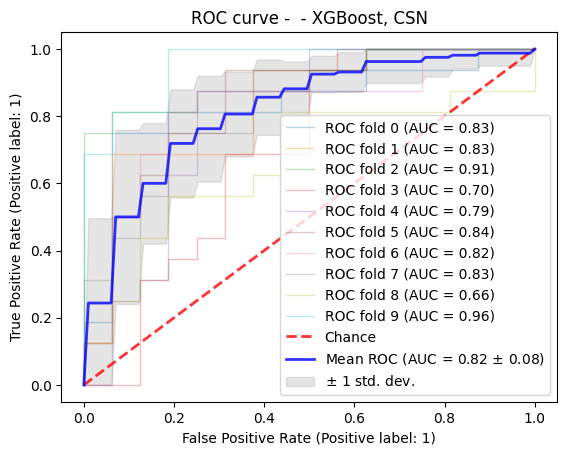

Random forest results:
LeaveOneOut()
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]

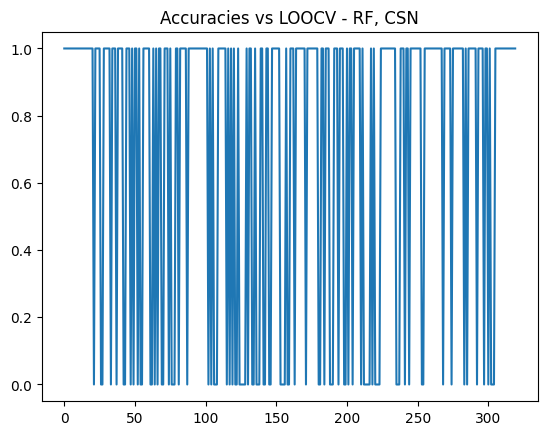

Average accuracy:
0.7
Indexes of misses:
[array([21]), array([26]), array([27]), array([33]), array([37]), array([42]), array([43]), array([47]), array([49]), array([52]), array([54]), array([55]), array([61]), array([62]), array([64]), array([66]), array([69]), array([70]), array([74]), array([76]), array([77]), array([78]), array([81]), array([87]), array([102]), array([104]), array([106]), array([107]), array([108]), array([115]), array([117]), array([119]), array([121]), array([122]), array([124]), array([125]), array([126]), array([127]), array([128]), array([130]), array([133]), array([134]), array([136]), array([137]), array([138]), array([141]), array([142]), array([145]), array([146]), array([153]), array([154]), array([155]), array([156]), array([158]), array([159]), array([163]), array([171]), array([180]), array([181]), array([184]), array([188]), array([189]), array([190]), array([194]), array([198]), array([199]), array([201]), array([204]), array([210]), array([212]), ar

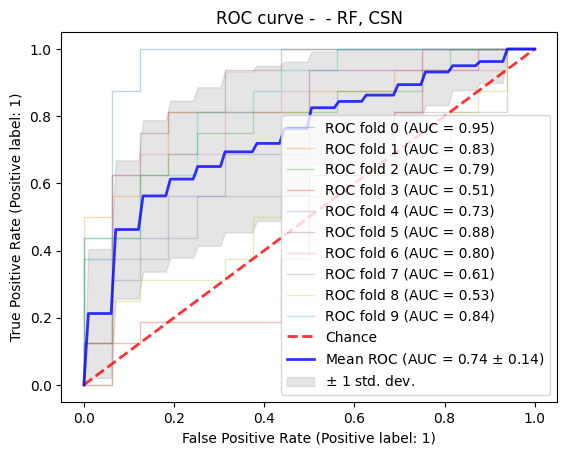

In [18]:
#CSN
#sys.exc_clear() 
U, X, y = prepare_data(to_drop=only_CSN)
print(list(X.head()))
print("XGBoost results:")
xgb_average_CSN, probas_xgb_CSN = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=xgb, details=" - XGBoost, CSN")
plot_average_ROC(classifier=xgb, details=" - XGBoost, CSN")
print("Random forest results:")
rfc_average_CSN, probas_rfc_CSN = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=rfc, details=" - RF, CSN")
plot_average_ROC(classifier=rfc, details=" - RF, CSN")
CSN_averages = xgb_average_CSN, rfc_average_CSN

['neighbour in SIGNOR', 'neighbour DisProt disorder content', 'neighbour preclinical target', 'neighbour MCG target', 'target in SIGNOR', 'target of small molecule', 'target of antibody', 'target DisProt IDP', 'target DisProt disorder content', 'both in SIGNOR', 'both in all 3', 'in  triangle - SIGNOR', 'not in any triangle', 'no. of triangles - SIGNOR', 'no. of in  cycle - SIGNOR', 'no. of in  unbalanced triangle - SIGNOR', 'neighbour – target inhibition - SIGNOR', 'target – neighbour stimulation - SIGNOR', 'neighbour – target stimulation - SIGNOR', 'target – neighbour inhibition - SIGNOR', 'DisProt neighbour third partner - SIGNOR', 'target third partner - SIGNOR', 'neighbour bridgeness - SIGNOR', 'neighbour betweenness - SIGNOR', 'target bridgeness - SIGNOR', 'target betweenness - SIGNOR']
XGBoost results:
LeaveOneOut()
[0]
[18:25:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This coul

[18]
[18:25:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19]
[18:25:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20]
[18:25:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[38]
[18:25:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[39]
[18:25:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[40]
[18:25:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[58]
[18:25:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[59]
[18:25:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[60]
[18:25:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[78]
[18:25:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[79]
[18:25:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[80]
[18:25:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[98]
[18:25:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[99]
[18:25:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[100]
[18:25:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

[118]
[18:26:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[119]
[18:26:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[120]
[18:26:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[138]
[18:26:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[139]
[18:26:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[140]
[18:26:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[158]
[18:26:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[159]
[18:26:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[160]
[18:26:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[178]
[18:26:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[179]
[18:26:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[180]
[18:26:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[198]
[18:26:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[199]
[18:26:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[200]
[18:26:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[218]
[18:26:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[219]
[18:26:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[220]
[18:26:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[238]
[18:26:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[239]
[18:26:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[240]
[18:26:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[258]
[18:26:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[259]
[18:26:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[260]
[18:26:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[278]
[18:27:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[279]
[18:27:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[280]
[18:27:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[298]
[18:27:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[299]
[18:27:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[300]
[18:27:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[318]
[18:27:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[319]
[18:27:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




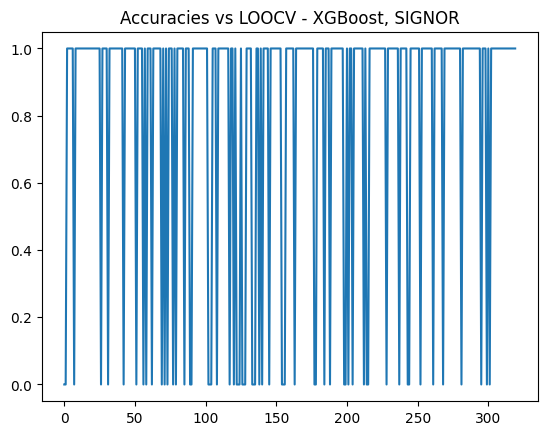

Average accuracy:
0.80625
Indexes of misses:
[array([0]), array([1]), array([7]), array([26]), array([31]), array([42]), array([51]), array([56]), array([58]), array([62]), array([69]), array([71]), array([73]), array([77]), array([79]), array([85]), array([89]), array([90]), array([102]), array([103]), array([104]), array([108]), array([117]), array([120]), array([122]), array([123]), array([124]), array([126]), array([127]), array([128]), array([133]), array([134]), array([135]), array([138]), array([140]), array([145]), array([154]), array([155]), array([156]), array([163]), array([177]), array([178]), array([184]), array([188]), array([198]), array([199]), array([201]), array([204]), array([212]), array([214]), array([215]), array([228]), array([237]), array([243]), array([244]), array([252]), array([261]), array([268]), array([281]), array([295]), array([299]), array([301])]
[18:27:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Param

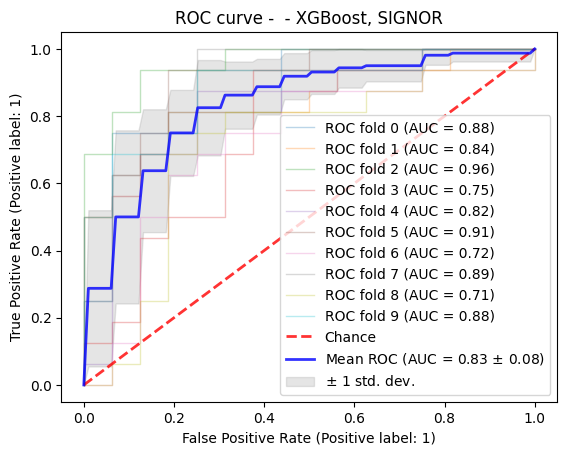

Random forest results:
LeaveOneOut()
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]

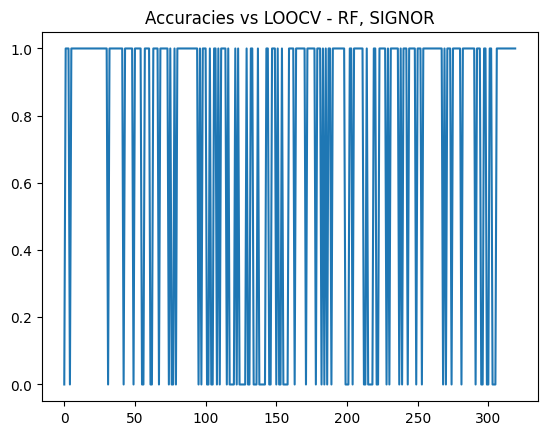

Average accuracy:
0.71875
Indexes of misses:
[array([0]), array([4]), array([31]), array([42]), array([49]), array([55]), array([56]), array([61]), array([62]), array([67]), array([74]), array([76]), array([77]), array([79]), array([95]), array([97]), array([101]), array([102]), array([104]), array([105]), array([108]), array([110]), array([115]), array([117]), array([118]), array([119]), array([120]), array([122]), array([124]), array([125]), array([126]), array([127]), array([128]), array([130]), array([131]), array([134]), array([135]), array([136]), array([138]), array([139]), array([140]), array([141]), array([142]), array([145]), array([146]), array([150]), array([152]), array([153]), array([155]), array([156]), array([157]), array([158]), array([163]), array([171]), array([178]), array([182]), array([184]), array([186]), array([189]), array([199]), array([200]), array([201]), array([204]), array([212]), array([213]), array([215]), array([216]), array([217]), array([218]), array(

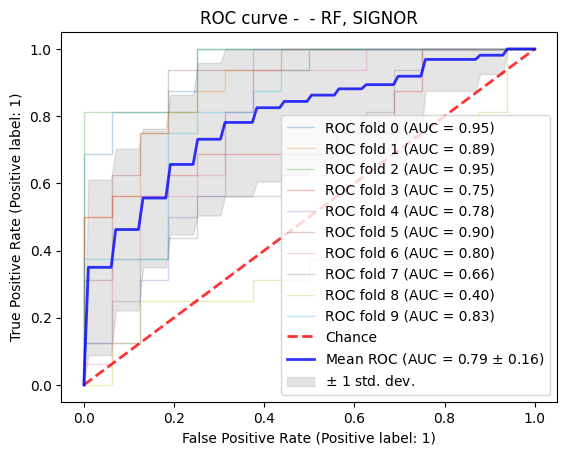

In [19]:
#SIGNOR
#sys.exc_clear() 
U, X, y = prepare_data(to_drop=only_SIGNOR)
print(list(X.head()))
print("XGBoost results:")
xgb_average_SIGNOR, probas_xgb_SIGNOR = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=xgb, details=" - XGBoost, SIGNOR")
plot_average_ROC(classifier=xgb, details=" - XGBoost, SIGNOR")
print("Random forest results:")
rfc_average_SIGNOR, probas_rfc_SIGNOR = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=rfc, details=" - RF, SIGNOR")
plot_average_ROC(classifier=rfc, details=" - RF, SIGNOR")
SIGNOR_averages = xgb_average_SIGNOR, rfc_average_SIGNOR

['neighbour in ReactomeFI', 'neighbour DisProt disorder content', 'neighbour preclinical target', 'neighbour MCG target', 'target in ReactomeFI', 'target of small molecule', 'target of antibody', 'target DisProt IDP', 'target DisProt disorder content', 'both in ReactomeFI', 'both in all 3', 'in  triangle - ReactomeFI', 'not in any triangle', 'no. of triangles - ReactomeFI', 'no. of in  cycle - ReactomeFI', 'no. of in  unbalanced triangle - ReactomeFI', 'neighbour – target inhibition - ReactomeFI', 'target – neighbour stimulation - ReactomeFI', 'neighbour – target stimulation - ReactomeFI', 'target – neighbour inhibition - ReactomeFI', 'DisProt neighbour third partner - ReactomeFI', 'target third partner - ReactomeFI', 'neighbour bridgeness - ReactomeFI', 'neighbour betweenness - ReactomeFI', 'target bridgeness - ReactomeFI', 'target betweenness - ReactomeFI']
XGBoost results:
LeaveOneOut()
[0]
[18:34:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.

[18]
[18:35:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19]
[18:35:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20]
[18:35:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[38]
[18:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[39]
[18:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[40]
[18:35:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[58]
[18:35:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[59]
[18:35:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[60]
[18:35:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[78]
[18:35:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[79]
[18:35:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[80]
[18:35:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.


[98]
[18:35:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[99]
[18:35:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[100]
[18:35:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

[118]
[18:35:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[119]
[18:35:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[120]
[18:35:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[138]
[18:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[139]
[18:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[140]
[18:35:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[158]
[18:35:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[159]
[18:35:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[160]
[18:35:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[178]
[18:35:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[179]
[18:35:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[180]
[18:35:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[198]
[18:36:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[199]
[18:36:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[200]
[18:36:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[218]
[18:36:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[219]
[18:36:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[220]
[18:36:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[238]
[18:36:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[239]
[18:36:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[240]
[18:36:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[258]
[18:36:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[259]
[18:36:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[260]
[18:36:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[278]
[18:36:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[279]
[18:36:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[280]
[18:36:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[298]
[18:36:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[299]
[18:36:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[300]
[18:36:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be use

[318]
[18:36:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[319]
[18:36:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




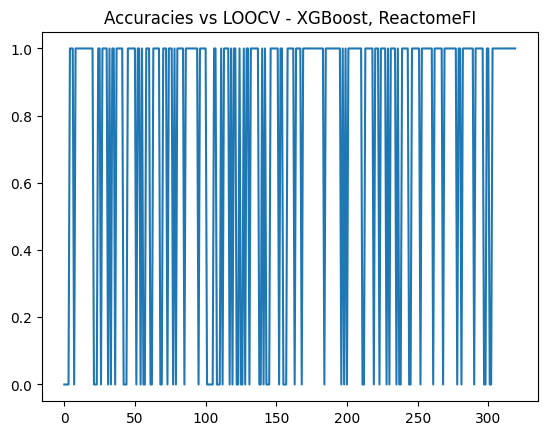

Average accuracy:
0.74375
Indexes of misses:
[array([0]), array([1]), array([2]), array([3]), array([7]), array([21]), array([22]), array([23]), array([26]), array([31]), array([33]), array([36]), array([42]), array([43]), array([44]), array([51]), array([54]), array([56]), array([57]), array([61]), array([62]), array([68]), array([69]), array([73]), array([77]), array([79]), array([85]), array([95]), array([101]), array([102]), array([103]), array([104]), array([105]), array([108]), array([109]), array([110]), array([112]), array([117]), array([119]), array([122]), array([123]), array([125]), array([126]), array([128]), array([131]), array([138]), array([139]), array([141]), array([143]), array([144]), array([145]), array([152]), array([155]), array([156]), array([157]), array([163]), array([168]), array([184]), array([196]), array([198]), array([200]), array([211]), array([212]), array([219]), array([223]), array([228]), array([230]), array([235]), array([237]), array([238]), array([

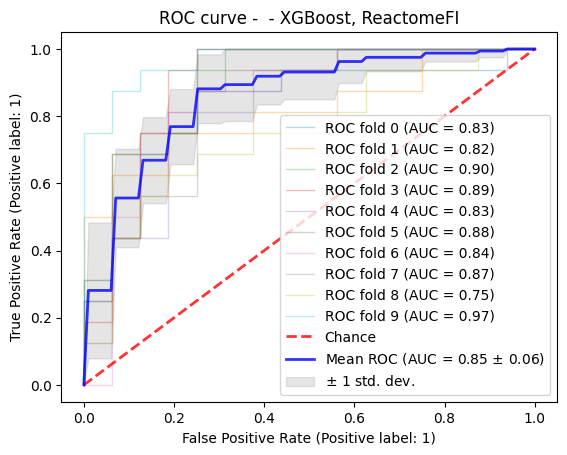

Random forest results:
LeaveOneOut()
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]

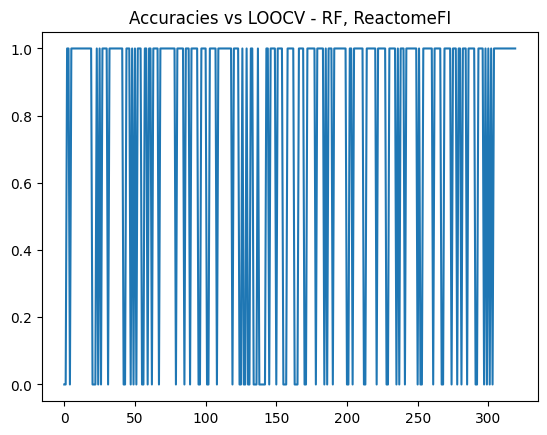

Average accuracy:
0.740625
Indexes of misses:
[array([0]), array([1]), array([4]), array([20]), array([21]), array([22]), array([24]), array([26]), array([31]), array([42]), array([43]), array([47]), array([49]), array([51]), array([55]), array([56]), array([59]), array([62]), array([67]), array([79]), array([85]), array([89]), array([95]), array([96]), array([101]), array([102]), array([108]), array([119]), array([124]), array([125]), array([127]), array([128]), array([130]), array([131]), array([134]), array([135]), array([136]), array([138]), array([139]), array([140]), array([141]), array([142]), array([145]), array([150]), array([155]), array([156]), array([157]), array([163]), array([164]), array([165]), array([170]), array([171]), array([178]), array([184]), array([186]), array([190]), array([200]), array([201]), array([204]), array([212]), array([213]), array([221]), array([228]), array([229]), array([235]), array([237]), array([241]), array([250]), array([252]), array([253]), 

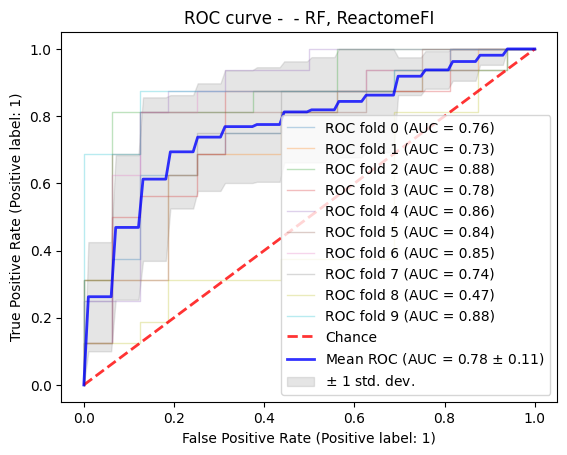

In [20]:
#ReactomeFI
#sys.exc_clear() 
U, X, y = prepare_data(to_drop=only_ReactomeFI)
print(list(X.head()))
print("XGBoost results:")
xgb_average_ReactomeFI, probas_xgb_ReactomeFI = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=xgb, details=" - XGBoost, ReactomeFI")
plot_average_ROC(classifier=xgb, details=" - XGBoost, ReactomeFI")
print("Random forest results:")
rfc_average_ReactomeFI, probas_rfc_ReactomeFI = LOOCV(X=X, y=y, machine_learning=teach_print_params, classifier=rfc, details=" - RF, ReactomeFI")
plot_average_ROC(classifier=rfc, details=" - RF, ReactomeFI")
ReactomeFI_averages = xgb_average_ReactomeFI, rfc_average_ReactomeFI

{'all': (0.76875, 0.725), 'CSN': (0.771875, 0.7), 'SIGNOR': (0.80625, 0.71875), 'ReactomeFI': (0.74375, 0.740625)}
             XGBoost  Random forest
all         0.768750       0.725000
CSN         0.771875       0.700000
SIGNOR      0.806250       0.718750
ReactomeFI  0.743750       0.740625


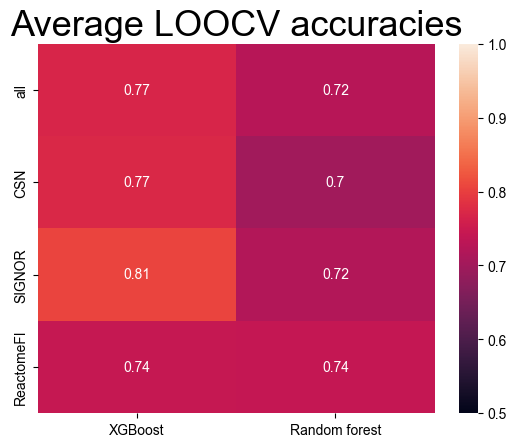

In [21]:
acc_dict = {'all':basic_averages, 'CSN': CSN_averages, 'SIGNOR': SIGNOR_averages, 'ReactomeFI': ReactomeFI_averages}
print(acc_dict)
accuracies = pd.DataFrame(acc_dict)
accuracies = accuracies.transpose()
accuracies = accuracies.set_axis(["XGBoost", "Random forest"], axis=1)
sns.heatmap(accuracies, annot=True, vmin=0.5, vmax=1)
plt.title("Average LOOCV accuracies", size=26)
sns.set(font_scale=1.4)
#sns.set(rc={'figure.facecolor':'#CCECFF'})
plt.rcParams["font.family"] = "Bahnschrift"
print(accuracies)

In [22]:
probas_all = pd.concat([training.iloc[:, :2], training.iloc[:, 17:19],
                        probas_xgb, probas_rfc, probas_xgb_CSN, probas_rfc_CSN, 
                        probas_xgb_SIGNOR, probas_rfc_SIGNOR, probas_xgb_ReactomeFI, probas_rfc_ReactomeFI], axis=1)
probas_all.columns = ['neighbour UniProt', 'neighbour name - universal', 'target UniProt', 'target name - universal',
                      'label xgb', 'proba xgb 0', 'proba xgb 1', 
                      'label rfc', 'proba rfc 0', 'proba rfc 1',
                      'CSN label xgb', 'CSN proba xgb 0', 'CSN proba xgb 1', 
                      'CSN label rfc', 'CSN proba rfc 0', 'CSN proba rfc 1',
                      'SIGNOR label xgb','SIGNOR proba xgb 0', 'SIGNOR proba xgb 1', 
                      'SIGNOR label rfc', 'SIGNOR proba rfc 0', 'SIGNOR proba rfc 1',
                      'ReactomeFI label xgb', 'ReactomeFI proba xgb 0', 'ReactomeFI proba xgb 1', 
                      'ReactomeFI label rfc', 'ReactomeFI proba rfc 0', 'ReactomeFI proba rfc 1']

In [23]:
probas_all

,neighbour UniProt,neighbour name - universal,target UniProt,target name - universal,label xgb,proba xgb 0,proba xgb 1,label rfc,proba rfc 0,proba rfc 1,...,SIGNOR proba xgb 1,SIGNOR label rfc,SIGNOR proba rfc 0,SIGNOR proba rfc 1,ReactomeFI label xgb,ReactomeFI proba xgb 0,ReactomeFI proba xgb 1,ReactomeFI label rfc,ReactomeFI proba rfc 0,ReactomeFI proba rfc 1
0,Q07817,BCL2L1,P10415,BCL2,"0 1 Name: neighbour biomarker for target?, ...",[0.818725],[0.18127498],"0 1 Name: neighbour biomarker for target?, ...",[0.5478005306047002],[0.4521994693952996],...,[0.06358422],"0 1 Name: neighbour biomarker for target?, ...",[0.5310107687910305],[0.46898923120896946],"0 1 Name: neighbour biomarker for target?, ...",[0.96738565],[0.032614347],"0 1 Name: neighbour biomarker for target?, ...",[0.6329265453394439],[0.3670734546605543]
1,O43521,BIM,P10415,BCL2,"1 1 Name: neighbour biomarker for target?, ...",[0.8887685],[0.11123152],"1 1 Name: neighbour biomarker for target?, ...",[0.5563967031695243],[0.4436032968304751],...,[0.018563863],"1 1 Name: neighbour biomarker for target?, ...",[0.4701635717664237],[0.5298364282335765],"1 1 Name: neighbour biomarker for target?, ...",[0.99482644],[0.0051735393],"1 1 Name: neighbour biomarker for target?, ...",[0.7126558369571032],[0.2873441630428954]
2,P04637,TP53,P10415,BCL2,"2 1 Name: neighbour biomarker for target?, ...",[0.5929252],[0.40707478],"2 1 Name: neighbour biomarker for target?, ...",[0.27816693704022155],[0.7218330629597814],...,[0.83556736],"2 1 Name: neighbour biomarker for target?, ...",[0.2423072446823151],[0.7576927553176879],"2 1 Name: neighbour biomarker for target?, ...",[0.6898813],[0.31011865],"2 1 Name: neighbour biomarker for target?, ...",[0.47476650513698426],[0.525233494863016]
3,P63000,RAC1,P15056,BRAF,"3 1 Name: neighbour biomarker for target?, ...",[0.8822556],[0.11774438],"3 1 Name: neighbour biomarker for target?, ...",[0.3379421033616415],[0.6620578966383591],...,[0.9887842],"3 1 Name: neighbour biomarker for target?, ...",[0.34635519918290875],[0.6536448008170929],"3 1 Name: neighbour biomarker for target?, ...",[0.55806],[0.44194],"3 1 Name: neighbour biomarker for target?, ...",[0.3775655955600567],[0.6224344044399441]
4,P06400,RB1,Q00534,CDK6,"4 1 Name: neighbour biomarker for target?, ...",[0.41241878],[0.5875812],"4 1 Name: neighbour biomarker for target?, ...",[0.5218159619905773],[0.47818403800942266],...,[0.5546378],"4 1 Name: neighbour biomarker for target?, ...",[0.5451453104400282],[0.4548546895599712],"4 1 Name: neighbour biomarker for target?, ...",[0.29532862],[0.7046714],"4 1 Name: neighbour biomarker for target?, ...",[0.5728731208249856],[0.42712687917501324]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Q9UJX4,ANAPC5,P28074,PSMB5,315 0 Name: neighbour biomarker for target?...,[0.9989014],[0.0010985574],315 0 Name: neighbour biomarker for target?...,[0.8084117790735784],[0.19158822092642425],...,[0.020170381],315 0 Name: neighbour biomarker for target?...,[0.7639666275080403],[0.23603337249196243],315 0 Name: neighbour biomarker for target?...,[0.99854416],[0.0014558731],315 0 Name: neighbour biomarker for target?...,[0.7083045142303388],[0.2916954857696625]
316,Q9UJX3,ANAPC7,P28074,PSMB5,316 0 Name: neighbour biomarker for target?...,[0.9989014],[0.0010985574],316 0 Name: neighbour biomarker for target?...,[0.8157889132478057],[0.1842110867521968],...,[0.020170381],316 0 Name: neighbour biomarker for target?...,[0.7829077835732517],[0.21709221642675078],316 0 Name: neighbour biomarker for target?...,[0.9979413],[0.002058675],316 0 Name: neighbour biomarker for target?...,[0.7271321008467435],[0.2728678991532577]
317,P60896,SEM1,O14788,TNFSF11,317 0 Name: neighbour biomarker for target?...,[0.9996539],[0.00034611483],317 0 Name: neighbour biomarker for target?...,[0.8275389168533692],[0.17246108314663264],...,[0.0013762481],317 0 Name: neighbour biomarker for target?...,[0.7990070454905827],[0.2009929

In [24]:
probas_all.to_excel("LOOCV_probas_DisProt.xlsx")